# EXPLORATORY DATA ANALYSIS & MODELING
Taking a quick look at the top 30 words per subreddit, it can be recognized that there are many common words between both subreddits. There are also some URL element (ie. 'www' , 'https',...) that are captured. Therefore, the text was cleaned up:
- all lower-cased
- omitting URL elements,
- omitting non-letters 

Stop words were not removed during cleaning for the sake of tuning while training models. Instead, a custom stop word list was created by combining the standing English list with all commonly shared words between both subreddits within the top 30. This gave 3 options of stop word treatment:
1. No removal of stop words
2. Removal of standard library "English" stop words
3. Removal of custom stop words ("English" + commonly shared words)

In order to select the best models for hyperparameter tuning, the cross validation scores all combinations of *Count and TF-IDF Vectorization* and the following models were compared:
- Logistic Regression
- KNN
- BernoulliNB
- MultinomialNB
- Random Forest Classifier
- SVC (Support Vector Classifier)
- AdaBoost Classifer

The top models considered for tuning were:
1. Logistic Regression
2. Random Forest Classifier
3. SVC
4. AdaBoost Classifier

**Through tuning, the best 2 models are:**
1. **AdaBoost Classifier with Count Vectorization (lowest variance)**
2. **SVC with TF-IDF Vectorization (highest ROC_AUC score + lowest bias)**

As for feature importance, each model had different sets of features due to the having different stop word treatments.
- AdaBoost + Count used the standard 'English' stop words
- SVC+TF-IDF used the custom stop words (the extended version of 'English' list including commonly shared words between both subreddits) 

1. (AdaBoost + Count) Approximately the top 4000 features were two word combinations that consisted of game/games/gaming + another word. 
    - Exceptions: "youtube damn" & "cores radeon"


2. (SVC + TF-IDF) Had very distinct single words that had the highest (& lowest) coefficients towards predicting if the post was from r/pcgaming.
    - Examples: pc, windows, laptop, xbox, playstation/ps, console/consoles
  
  
**Conclusion:**
<br>The two models selected mentioned would be the best models to utilize towards predicting whether a post is from r/pcgaming or r/consoles.
<br>**Despite having more variance, I personally would go for the SCV+TF-IDF model as it exhibits strong separability performance with the highest level of training and test accuracy.**

**Recommendation:**
1. Include lemmatization/stemming in the tuning process
    - Potentially better scores may exist and the feature importances could narrow down
2. Implement image processing due to many posts being image-only
3. Re-conduct the analysis when the r/consoles community has expanded to have a minimum of 10000 posts
    - Due to imblanced samples from each subreddit (more r/pcgaming vs. r/consoles)

## 1. EDA

In [32]:
# Imports

# Standard imports
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import re

# Natural Language Processing
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Warnings Ignored
import warnings
warnings.filterwarnings('ignore')

In [33]:
# Clean data read
df = pd.read_csv('../data/submissions_clean.csv')

### Most common words in Console Gaming
- Looking at top 30 for now without cleaning

In [34]:
# Count vectorizer instantiated
cvec = CountVectorizer(stop_words='english', max_features=30)

## max_features=30 to only review the top 30

**CONSOLE GAMING**

In [35]:
# Console gaming data extracted
cons_text = df[df['subreddit']==0]['text']

# Count stored into DataFrame for analysis
cons_count = pd.DataFrame(cvec.fit_transform(cons_text).toarray(),
                          columns = cvec.get_feature_names())

# Top 20 words and frequencies
cons_count.sum().sort_values(ascending=False)

xbox        3107
games       2677
console     2439
ps4         1935
game        1896
like        1379
play        1242
just        1196
consoles    1181
ps5         1019
switch      1006
new          931
series       902
buy          894
pc           864
know         799
gaming       789
want         758
ve           736
nintendo     731
don          728
really       704
time         663
com          589
amp          575
better       558
think        552
https        538
best         532
looking      523
dtype: int64

**PC GAMING**

In [36]:
# PC gaming data extracted
pc_text = df[df['subreddit']==1]['text']

# Count stored into DataFrame for analysis
pc_count = pd.DataFrame(cvec.fit_transform(pc_text).toarray(),
                          columns = cvec.get_feature_names())

# Top 20 words and frequencies
pc_count.sum().sort_values(ascending=False)

pc         2344
game       2200
games      1758
gaming      961
steam       785
new         782
just        724
like        700
help        698
https       682
play        669
good        577
com         543
amp         450
need        448
know        403
looking     378
trailer     374
time        361
www         355
2021        346
don         330
want        326
free        308
best        307
ve          290
playing     287
xbox        278
people      269
buy         264
dtype: int64

In [37]:
# Commonly shared words
for i in pc_count.columns:
    if i in cons_count.columns:
        print(i)

amp
best
buy
com
don
game
games
gaming
https
just
know
like
looking
new
pc
play
time
ve
want
xbox


**Both subreddits share many common words that can be omitted as a stop word, but will be kept for ngram observations:**
- pc
- xbox
- just
- like
- know
- new
- play
- best
- buy
- don
- game
- games
- gaming
- looking
- time
- ve
- want

**Also, elements of URLs are considered top words in PC Gaming, which can also be omitted as stop words:**
- https
- com
- www
- amp

### CLEANING TEXT

In [38]:
# Text cleaning method defined

def clean(text):
    
    # Remove any HTML tags in-case
    text = BeautifulSoup(text).get_text()
    
    # Remove non-letters
    text = re.sub("[^a-zA-Z]", " ", text)
    
    # Convert to lower case, split into individual words
    words = text.lower().split()
    
    # Removed URL elements observed
    # (will only remove stop words during vectorization)
    url_elements = ['https', 'http', 'www', 'reddit', 'com',
                  'comment']
    main_words = [w for w in words if w not in url_elements]

    # Return single string
    return(" ".join(main_words))

In [39]:
# Applied text cleaning method
df['text'] = df['text'].apply(clean)

In [40]:
# Quick review
df.head()

,subreddit,text
0,1,cat loves to jump on my pc
1,1,need help with hacked epic account
2,1,auto hdr preview for pc available today direct...
3,1,accidentally pissed on my gaming pc now im rea...
4,1,are black ops and waw active on pc hi all are ...


### Word count analysis repeated

In [41]:
# Console gaming data extracted
cons_text = df[df['subreddit']==0]['text']

# Count stored into DataFrame for analysis
cons_count = pd.DataFrame(cvec.fit_transform(cons_text).toarray(),
                          columns = cvec.get_feature_names())

# Top 20 words and frequencies
cons_count.sum().sort_values(ascending=False)

ps             3958
xbox           3151
games          2677
console        2439
game           1908
like           1379
play           1242
just           1198
consoles       1190
switch         1007
new             932
series          903
buy             894
pc              866
know            799
gaming          789
want            758
ve              736
nintendo        734
don             728
really          704
time            663
better          558
think           552
best            532
looking         523
playstation     517
help            502
good            501
controller      496
dtype: int64

In [1]:
# Horizontal bar chart for visual
cons_words = cons_count.sum().sort_values(ascending=False)

plt.figure(figsize=(8,8))
plt.title('TOP 20 WORDS IN R/CONSOLES', weight='bold')
plt.barh(cons_words.index, cons_words)
plt.gca().invert_yaxis()
plt.savefig('../images/top20_console.png', dpi=75)

NameError: name 'cons_count' is not defined

In [43]:
# PC gaming data extracted
pc_text = df[df['subreddit']==1]['text']

# Count stored into DataFrame for analysis
pc_count = pd.DataFrame(cvec.fit_transform(pc_text).toarray(),
                          columns = cvec.get_feature_names())

# Top 20 words and frequencies
pc_count.sum().sort_values(ascending=False)

pc         2346
game       2205
games      1759
gaming      963
steam       788
new         782
just        727
like        700
help        698
play        671
good        578
need        448
know        403
looking     378
trailer     374
time        361
don         330
want        326
free        317
best        307
fps         295
ve          290
playing     287
xbox        279
people      269
buy         264
use         254
make        246
really      235
ps          230
dtype: int64

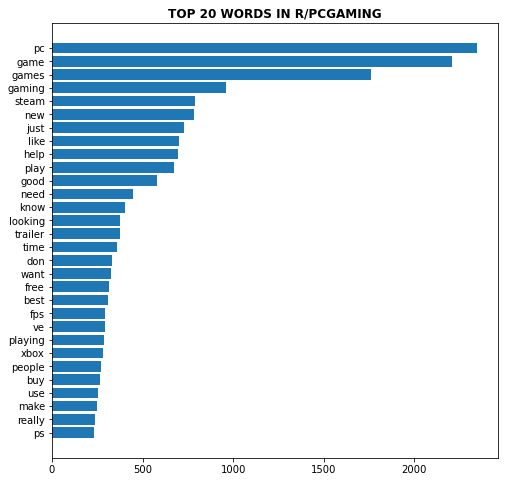

In [44]:
# Horizontal bar chart for visual
pc_words = pc_count.sum().sort_values(ascending=False)

plt.figure(figsize=(8,8))
plt.title('TOP 20 WORDS IN R/PCGAMING', weight='bold')
plt.barh(pc_words.index, pc_words)
plt.gca().invert_yaxis()
plt.savefig('../images/top20_pc.png', dpi=75)

## Customized stop words

In [45]:
# Common words between both
common_words = []

for i in pc_count.columns:
    if i in cons_count.columns:
        common_words.append(i)
        
## The commonly shared words are stored for now
## Excluding significant words like pc, ps and xbox
common_words.remove('pc')
common_words.remove('ps')
common_words.remove('xbox')
print(common_words)

['best', 'buy', 'don', 'game', 'games', 'gaming', 'good', 'help', 'just', 'know', 'like', 'looking', 'new', 'play', 'really', 'time', 've', 'want']


In [46]:
# New stop words list created
stops = stopwords.words('english')
stops.extend(common_words)
stops = set(stops)

## 2. MODELING
3 functions are created:
1. evaluation() -- displays all classification scores & confusion matrix
2. pipe() -- pipelines different combinations of vectorizors and classifier-models
3. grid() -- hypertunes the best parameters of pipeline under GridSearchCV

In [47]:
# Imports

# Modeling Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Pipeline
from sklearn.pipeline import Pipeline

# Machine Learning
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Floating point output displayed set to 5 digits after decimal
# Their true un-rounded values will still be used in calculations 
np.set_printoptions(precision=5)

**EVALUATION METHOD**

Displays the Testing Accuracy along with it's scores:
- precision
- recall
- accuracy
- f1 (harmonic mean of precision + recall)
- roc_auc

In [48]:
# Classification score and confusion matrix 
def evaluation(actual, pred, title = 'Confusion Matrix'):
    cm = confusion_matrix(actual, pred)
    precision = precision_score(actual, pred)
    recall = recall_score(actual, pred)
    accuracy = accuracy_score(actual, pred)
    f1 = f1_score(actual, pred)
    roc_auc = roc_auc_score(actual, pred)
    
    print('TEST:')
    print('Accuracy: ', accuracy)
    print('\nRecall: ', recall)
    print('Precision: ', precision)
    print('F1: ', f1)
    print('ROC_AUC: ', roc_auc)
    
    sns.heatmap(cm, cmap= 'cividis', annot=True, fmt='g', annot_kws={'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show();

**PIPELINE METHOD**

Pipelines the vectorizer + classification model of choice & displays:
- cross validation training score
- test scores (from calling the evaluation method above)

In [49]:
# Pipeline method (also calls the evalation() method within)
def pipe(vectorizer, model):
    #Pipeline vectorizer + estimator
    pipe = Pipeline([
        ('vec', vectorizer),
        ('model', model)
    ])
    
    pipe.fit(X_train, y_train)
    
    train_score = pipe.score(X_train,y_train)
    pred = pipe.predict(X_test) 

    print('TRAINING:')
    print(f'Accuracy: {train_score}')
    print()
    evaluation(y_test, pred) # output values

**Variables defined**

In [50]:
# Feature and Target defined
X = df['text']
y = df['subreddit']

In [51]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

**Baseline Accuracy**
- 0.642425 for the majority class (PC Gaming)

In [52]:
y_test.value_counts(normalize=True)

1    0.642425
0    0.357575
Name: subreddit, dtype: float64

## INITIAL LOOK WITH INDIVIDUAL PIPELINES
We'll observe combinations of differnt combinations of Logistic Regression + Count or TF-IDF Vectorizer. With the different stop word treatments:
1. No stop words removed
2. Standard English stop words removed
3. Customized stop words removed (English + commonly observed words)

**Count Vectorizer + Logistic Regression:**

TRAINING:
Accuracy: 0.9609049414566382

TEST:
Accuracy:  0.8998791297340855

Recall:  0.9548447789275635
Precision:  0.8961153619776339
F1:  0.924548352816153
ROC_AUC:  0.8779857697454718


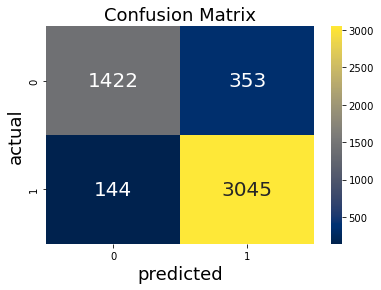

In [53]:
# Count Vectorizer, no stop word removal + Logistic Regression
pipe(CountVectorizer(),
    LogisticRegression(solver='liblinear'))

TRAINING:
Accuracy: 0.9554475094264735

TEST:
Accuracy:  0.8978646253021757

Recall:  0.9576669802445907
Precision:  0.8914185639229422
F1:  0.9233560090702948
ROC_AUC:  0.8740447577279291


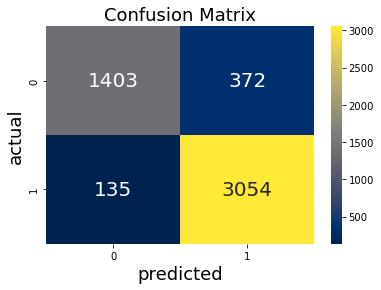

In [54]:
# Count Vectorizer, stop word removal v+ Logistic Regression
pipe(CountVectorizer(stop_words='english'),
    LogisticRegression(solver='liblinear'))

TRAINING:
Accuracy: 0.9551498313157373

TEST:
Accuracy:  0.9010878323932313

Recall:  0.9604891815616181
Precision:  0.8935239206534422
F1:  0.9257971890584857
ROC_AUC:  0.8774276893723584


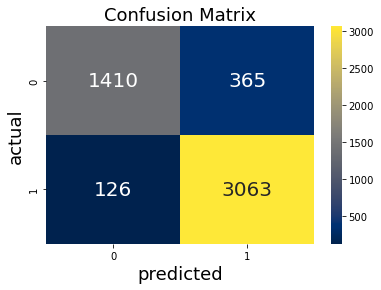

In [55]:
# Count Vectorizer, extened English stop words removed + Logistic Regression
pipe(CountVectorizer(stop_words=stops),
    LogisticRegression(solver='liblinear'))

**TF-IDF Vectorizer + Logistic Regression:**

TRAINING:
Accuracy: 0.9133756697757491

TEST:
Accuracy:  0.9000805801772764

Recall:  0.9689557855126999
Precision:  0.8861485517636937
F1:  0.9257040143798682
ROC_AUC:  0.8726469068408571


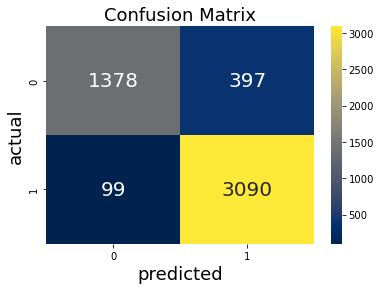

In [56]:
# TFIDF Vectorizer, no stop word removal + Logistic Regression
pipe(TfidfVectorizer(),
    LogisticRegression(solver='liblinear'))

TRAINING:
Accuracy: 0.9130779916650129

TEST:
Accuracy:  0.895447219983884

Recall:  0.971464408905613
Precision:  0.8786159954622802
F1:  0.92271034996277
ROC_AUC:  0.8651688241711165


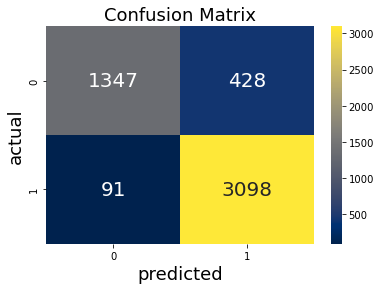

In [57]:
# TFIDF Vectorizer, stop word removal v+ Logistic Regression
pipe(TfidfVectorizer(stop_words='english'),
    LogisticRegression(solver='liblinear'))

TRAINING:
Accuracy: 0.9104981147052986

TEST:
Accuracy:  0.8966559226430298

Recall:  0.9708372530573848
Precision:  0.8805460750853242
F1:  0.9234899328859061
ROC_AUC:  0.8671087673737627


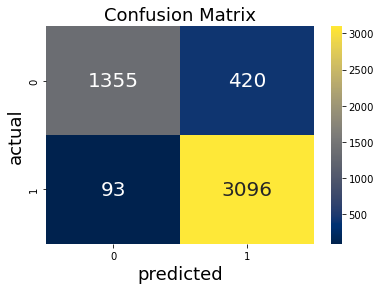

In [58]:
# TFIDF Vectorizer, my stop word list removed + Logistic Regression
pipe(TfidfVectorizer(stop_words=stops),
    LogisticRegression(solver='liblinear'))

**OBSERVATIONS:**
- All logistic regression models are overfit regardless of vectorizer used
    - TF-IDF with no stop word removed has the lowest bias & variance

We'll further confirm with choosing the best 3 models based on cross-validation scores & hypertuning the parameters using the grid() method defined in the hypertuning section below.

## BEST MODEL SELECTION
Based on the cross validation scores of each model at default settings.

In [59]:
# Dictionary of all models for iteration
models = {
    'Logistic Regression':LogisticRegression(solver='liblinear'),
    'KNN':KNeighborsClassifier(),
    'BernoulliNB': BernoulliNB(),
    'MultinomialNB': MultinomialNB(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVC': SVC(random_state=42),
    'AdaBoosting':AdaBoostClassifier(random_state=42)
}

**Count Vectorizer**

In [60]:
# Iteration to generate 5-fold cross-valuation scores for each default model
print('COUNT VECTORIZER')
for name, model in models.items():
    pipe = Pipeline([
        ('vec', CountVectorizer()),
        ('model', model)
    ])
    
    cv_score = cross_val_score(pipe, X_train, y_train, cv=5).mean()
    print(f'{name}: {cv_score}')

COUNT VECTORIZER
Logistic Regression: 0.8894618240182754
KNN: 0.7670136181023277
BernoulliNB: 0.7408194493678365
MultinomialNB: 0.8499691795659536
Random Forest: 0.8744770865335383
SVC: 0.8701130903147032
AdaBoosting: 0.8802334672495963


**TF-IDF Vectorizer**

In [61]:
# Iteration to generate 5-fold cross-valuation scores for each default model
print('TF-IDF VECTORIZER')
for name, model in models.items():
    pipe = Pipeline([
        ('vec', TfidfVectorizer()),
        ('model', model)
    ])
    
    cv_score = cross_val_score(pipe, X_train, y_train, cv=5).mean()
    print(f'{name}: {cv_score}')

TF-IDF VECTORIZER
Logistic Regression: 0.8823173421560518
KNN: 0.6003116999487967
BernoulliNB: 0.7408194493678365
MultinomialNB: 0.8638605301508526
Random Forest: 0.880430402930403
SVC: 0.8921406908503684
AdaBoosting: 0.8797379770766869


### TOP MODELS:
1. Logistic Regression
2. Random Forest Classifier
3. Support Vector Classifier
4. Adaptive Boost Classifier
    
Since all vectorizers don't remove stop words by default, we'll tune for both vectorizers on all 3 models while accounting for the 3 options of stop word treatment:
1. No stop words removed
2. Standard English stop words removed
3. Customized stop words removed (English + commonly observed words)

## HYPERTUNING PARAMETERS

**GRIDSEARCHCV METHOD**

Similar to the Pipeline method above, but displays:
- best training score
- testing scores (from calling the evaluation method above)
- best parameters

In [22]:
# GridSearchCV method (also calls the evalation() method within)
def grid(vectorizer, model, params, cv=3):
    #Grid Search on Pipeline of vectorizer + estimator
    grid = GridSearchCV(Pipeline([('vec', vectorizer),
                                  ('model', model)]),
                        params,
                        cv=cv,
                        verbose=1)
    
    # Fit on training
    grid.fit(X_train, y_train)
    
    # Extact best estimators & refit on training
    best = grid.best_estimator_
    best.fit(X_train, y_train)
    
    best_score = best.score(X_train, y_train)
    pred = best.predict(X_test) 
    
    print('TRAINING:')
    print(f'Accuracy: {best_score}')
    print()
    evaluation(y_test, pred) # output values
    print(f'\nBEST PARAMETERS: {grid.best_params_}\n')

In [21]:
import time

### HYPTERTUNING WITH GRIDSEARCHCV
For the top 3 models with both vectorizers:
1. Logistic Regression
2. Random Forest Classifier
3. Support Vector Classifier

**Count Vectorization + Logistic Regression**

Fitting 3 folds for each of 36 candidates, totalling 108 fits
TRAINING:
Accuracy: 0.981543957134352

TEST:
Accuracy:  0.9071313456889605

Recall:  0.9695829413609282
Precision:  0.8946759259259259
F1:  0.9306245297215953
ROC_AUC:  0.8822562594128586


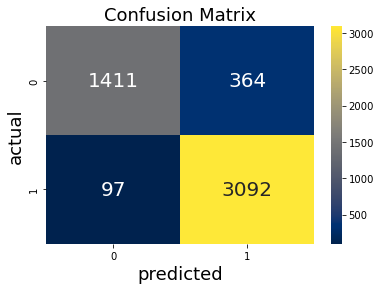


BEST PARAMETERS: {'model__penalty': 'l2', 'vec__max_features': None, 'vec__ngram_range': (1, 2), 'vec__stop_words': {'an', "shouldn't", 'like', "wasn't", 'when', "haven't", 'itself', 't', 'while', 'both', 'really', 'during', 'game', 'from', 'its', 'whom', 'is', 'do', "aren't", 'yourself', 'does', "couldn't", 'o', 'himself', 'or', 'against', 'themselves', 'own', 'weren', 'over', 'because', 'up', 'having', 'but', 'me', 'of', "shan't", 's', "doesn't", 'should', 'that', 'here', 'down', 'hasn', 'so', "you're", 'don', 'into', "hasn't", 'the', 'are', "you'd", "didn't", 'through', 'games', 'being', 'yours', 'mightn', 'needn', 'won', 've', "needn't", 'want', 'where', 'between', 'at', 'who', 'about', 'which', 'doing', "wouldn't", 'best', 'any', "weren't", 'help', 'this', 'shouldn', 'ourselves', 'i', 'for', 'what', 'no', 'and', 'further', 'new', 'wasn', 'only', 'isn', "don't", 'am', 'her', 'on', 'each', 'once', 'how', 'didn', 'nor', 'have', 'you', 'by', 'looking', 'after', "you'll", 'wouldn', 'h

In [66]:
%%time
# Parameters aligned with the method
    # vectorizer as 'vec'
    # model as 'model'
    
params = {
    'vec__stop_words':[None, 'english', stops],
    'vec__max_features':[None, 2000, 5000],
#     'vec__min_df':[None, 0.05, 0.1],
#     'vec__max_df':[None, 0.8, 0.9],
    'vec__ngram_range':[(1,1), (1,2)],
    'model__penalty':['l1', 'l2']
}

grid(CountVectorizer(), LogisticRegression(solver='liblinear'), params)

**TF-IDF Vectorizer + Logistic Regression**

Fitting 3 folds for each of 36 candidates, totalling 108 fits
TRAINING:
Accuracy: 0.9081166898194086

TEST:
Accuracy:  0.8974617244157937

Recall:  0.9655064283474444
Precision:  0.8852788959171938
F1:  0.9236538173091345
ROC_AUC:  0.8703588479765391


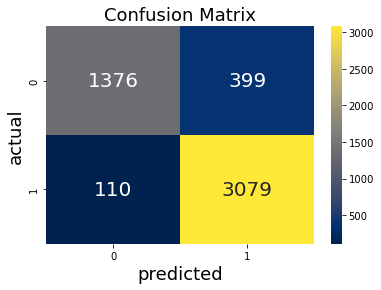


BEST PARAMETERS: {'model__penalty': 'l1', 'vec__max_features': 2000, 'vec__ngram_range': (1, 2), 'vec__stop_words': 'english'}

CPU times: user 59.2 s, sys: 292 ms, total: 59.5 s
Wall time: 30.4 s


In [67]:
%%time

params = {
    'vec__stop_words':[None, 'english', stops],
    'vec__max_features':[None, 2000, 5000],
#     'vec__min_df':[None, 0.05, 0.1],
#     'vec__max_df':[None, 0.8,0.9],
    'vec__ngram_range':[(1,1), (1,2)],
    'model__penalty':['l1', 'l2']
}

grid(TfidfVectorizer(), LogisticRegression(solver='liblinear'), params)

**Count Vectorizer + Random Forest Classifier**

Fitting 3 folds for each of 18 candidates, totalling 54 fits
TRAINING:
Accuracy: 0.9966263147449891

TEST:
Accuracy:  0.8944399677679291

Recall:  0.9354029476324867
Precision:  0.9036655558921539
F1:  0.9192604006163327
ROC_AUC:  0.8781240090275109


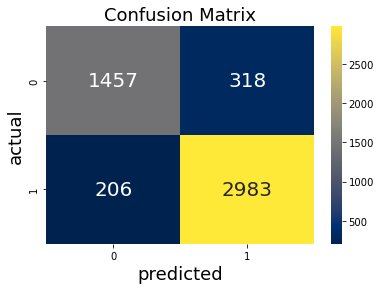


BEST PARAMETERS: {'model__class_weight': 'balanced_subsample', 'vec__ngram_range': (1, 2), 'vec__stop_words': {'an', "shouldn't", 'like', "wasn't", 'when', "haven't", 'itself', 't', 'while', 'both', 'really', 'during', 'game', 'from', 'its', 'whom', 'is', 'do', "aren't", 'yourself', 'does', "couldn't", 'o', 'himself', 'or', 'against', 'themselves', 'own', 'weren', 'over', 'because', 'up', 'having', 'but', 'me', 'of', "shan't", 's', "doesn't", 'should', 'that', 'here', 'down', 'hasn', 'so', "you're", 'don', 'into', "hasn't", 'the', 'are', "you'd", "didn't", 'through', 'games', 'being', 'yours', 'mightn', 'needn', 'won', 've', "needn't", 'want', 'where', 'between', 'at', 'who', 'about', 'which', 'doing', "wouldn't", 'best', 'any', "weren't", 'help', 'this', 'shouldn', 'ourselves', 'i', 'for', 'what', 'no', 'and', 'further', 'new', 'wasn', 'only', 'isn', "don't", 'am', 'her', 'on', 'each', 'once', 'how', 'didn', 'nor', 'have', 'you', 'by', 'looking', 'after', "you'll", 'wouldn', 'hers', 

In [68]:
%%time

params = {
    'vec__stop_words':[None, 'english',stops],
    'vec__ngram_range':[(1,1), (1,2)],
#     'model__max_depth': [80, 90, 100, 110],
#     'model__min_samples_leaf': [3, 4, 5],
#     'model__min_samples_split': [8, 10, 12],
#     'model__n_estimators': [100, 200, 300, 1000],
    'model__class_weight': [None, 'balanced', 'balanced_subsample']
}

grid(CountVectorizer(), RandomForestClassifier(n_jobs=-1, random_state=42), params)

**TF-IDF Vectorizer + Random Forest Classifier**

Fitting 3 folds for each of 18 candidates, totalling 54 fits
TRAINING:
Accuracy: 0.9963286366342529

TEST:
Accuracy:  0.9016921837228042

Recall:  0.9498275321417372
Precision:  0.9022937146261543
F1:  0.9254506568897037
ROC_AUC:  0.8825193998736856


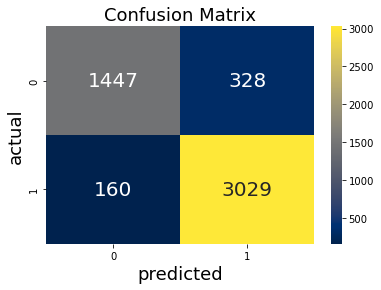


BEST PARAMETERS: {'model__class_weight': None, 'vec__ngram_range': (1, 1), 'vec__stop_words': {'an', "shouldn't", 'like', "wasn't", 'when', "haven't", 'itself', 't', 'while', 'both', 'really', 'during', 'game', 'from', 'its', 'whom', 'is', 'do', "aren't", 'yourself', 'does', "couldn't", 'o', 'himself', 'or', 'against', 'themselves', 'own', 'weren', 'over', 'because', 'up', 'having', 'but', 'me', 'of', "shan't", 's', "doesn't", 'should', 'that', 'here', 'down', 'hasn', 'so', "you're", 'don', 'into', "hasn't", 'the', 'are', "you'd", "didn't", 'through', 'games', 'being', 'yours', 'mightn', 'needn', 'won', 've', "needn't", 'want', 'where', 'between', 'at', 'who', 'about', 'which', 'doing', "wouldn't", 'best', 'any', "weren't", 'help', 'this', 'shouldn', 'ourselves', 'i', 'for', 'what', 'no', 'and', 'further', 'new', 'wasn', 'only', 'isn', "don't", 'am', 'her', 'on', 'each', 'once', 'how', 'didn', 'nor', 'have', 'you', 'by', 'looking', 'after', "you'll", 'wouldn', 'hers', 'with', 'ma', 's

In [69]:
%%time

params = {
    'vec__stop_words':[None,'english', stops],
    'vec__ngram_range':[(1,1), (1,2)],
#     'model__max_depth': [80, 90, 100, 110],
#     'model__min_samples_leaf': [3, 4, 5],
#     'model__min_samples_split': [8, 10, 12],
#     'base_estimator__n_estimators': [100, 200, 300, 1000],
    'model__class_weight': [None, 'balanced', 'balanced_subsample']
}

grid(TfidfVectorizer(), RandomForestClassifier(n_jobs=-1, random_state=42), params)

**Count Vectorizer + Support Vector Classifier**

Fitting 3 folds for each of 288 candidates, totalling 864 fits
TRAINING:
Accuracy: 0.9772772375471324

TEST:
Accuracy:  0.9037066881547139

Recall:  0.9639385387268736
Precision:  0.8943846377654932
F1:  0.9278599456685783
ROC_AUC:  0.8797157482366762


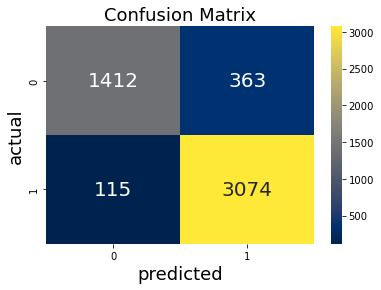


BEST PARAMETERS: {'model__C': 100, 'model__gamma': 0.001, 'model__kernel': 'rbf', 'vec__ngram_range': (1, 2), 'vec__stop_words': {'an', "shouldn't", 'like', "wasn't", 'when', "haven't", 'itself', 't', 'while', 'both', 'really', 'during', 'game', 'from', 'its', 'whom', 'is', 'do', "aren't", 'yourself', 'does', "couldn't", 'o', 'himself', 'or', 'against', 'themselves', 'own', 'weren', 'over', 'because', 'up', 'having', 'but', 'me', 'of', "shan't", 's', "doesn't", 'should', 'that', 'here', 'down', 'hasn', 'so', "you're", 'don', 'into', "hasn't", 'the', 'are', "you'd", "didn't", 'through', 'games', 'being', 'yours', 'mightn', 'needn', 'won', 've', "needn't", 'want', 'where', 'between', 'at', 'who', 'about', 'which', 'doing', "wouldn't", 'best', 'any', "weren't", 'help', 'this', 'shouldn', 'ourselves', 'i', 'for', 'what', 'no', 'and', 'further', 'new', 'wasn', 'only', 'isn', "don't", 'am', 'her', 'on', 'each', 'once', 'how', 'didn', 'nor', 'have', 'you', 'by', 'looking', 'after', "you'll",

In [70]:
%%time

params = {
    'vec__stop_words':[None, 'english',stops],
    'vec__ngram_range':[(1,1), (1,2)],
#     'model__max_depth': [80, 90, 100, 110],
#     'model__min_samples_leaf': [3, 4, 5],
#     'model__min_samples_split': [8, 10, 12],
#     'model__n_estimators': [100, 200, 300, 1000],
    'model__C':[0.1, 1, 10, 100],
    'model__kernel': ['rbf', 'poly', 'sigmoid'],
    'model__gamma': [1, 0.1, 0.01, 0.001],
}

grid(CountVectorizer(), SVC(random_state=42), params)

In [72]:
## SAVED OUTPUT DUE TO EXCESSIVE TIME TRAINING (Count Vectorizer + Support Vector Classifier)

    # Fitting 3 folds for each of 288 candidates, totalling 864 fits
    # TRAINING:
    # Accuracy: 0.9772772375471324

    # TEST:
    # Accuracy:  0.9037066881547139

    # Recall:  0.9639385387268736
    # Precision:  0.8943846377654932
    # F1:  0.9278599456685783
    # ROC_AUC:  0.8797157482366762


    # BEST PARAMETERS: {'model__C': 100, 'model__gamma': 0.001, 'model__kernel': 'rbf', 'vec__ngram_range': (1, 2), 'vec__stop_words': {'an', "shouldn't", 'like', "wasn't", 'when', "haven't", 'itself', 't', 'while', 'both', 'really', 'during', 'game', 'from', 'its', 'whom', 'is', 'do', "aren't", 'yourself', 'does', "couldn't", 'o', 'himself', 'or', 'against', 'themselves', 'own', 'weren', 'over', 'because', 'up', 'having', 'but', 'me', 'of', "shan't", 's', "doesn't", 'should', 'that', 'here', 'down', 'hasn', 'so', "you're", 'don', 'into', "hasn't", 'the', 'are', "you'd", "didn't", 'through', 'games', 'being', 'yours', 'mightn', 'needn', 'won', 've', "needn't", 'want', 'where', 'between', 'at', 'who', 'about', 'which', 'doing', "wouldn't", 'best', 'any', "weren't", 'help', 'this', 'shouldn', 'ourselves', 'i', 'for', 'what', 'no', 'and', 'further', 'new', 'wasn', 'only', 'isn', "don't", 'am', 'her', 'on', 'each', 'once', 'how', 'didn', 'nor', 'have', 'you', 'by', 'looking', 'after', "you'll", 'wouldn', 'hers', 'with', 'ma', 'shan', 'she', "she's", 'hadn', 'in', 'all', 'some', 'he', 'm', "hadn't", 'yourselves', 'ain', 'until', 'my', 'buy', 'been', 'most', 'such', 'was', 'ours', 'doesn', 'just', "isn't", 'above', 'too', 'myself', "should've", 'other', 'off', 'will', "mustn't", 'haven', 'same', 'if', 'to', 'aren', 'play', 'than', 'couldn', "won't", 'those', "you've", 'your', 'can', 'not', "mightn't", 'then', 'it', 'out', 'under', 'as', 'd', 'before', 'mustn', 'good', 'y', 'time', 'his', 'had', 'their', "it's", 'll', 'gaming', 'below', 'them', 're', 'know', 'now', 'our', 'very', 'be', 'again', 'more', 'a', 'why', 'these', 'they', 'did', 'there', "that'll", 'theirs', 'were', 'we', 'few', 'him', 'herself', 'has'}}

    # CPU times: user 1h 13min 39s, sys: 14.2 s, total: 1h 13min 53s
    # Wall time: 1h 13min 54s

**TF-IDF Vectorizer + Support Vector Classifier**

Fitting 3 folds for each of 288 candidates, totalling 864 fits
TRAINING:
Accuracy: 0.983726929946418

TEST:
Accuracy:  0.911563255439162

Recall:  0.9614299153339605
Precision:  0.9065641632170314
F1:  0.9331912950844621
ROC_AUC:  0.8917008731599381


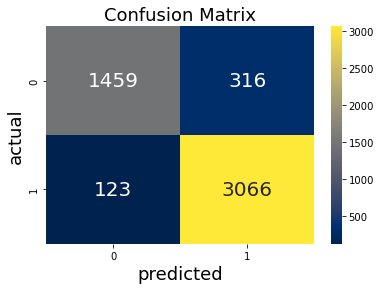


BEST PARAMETERS: {'model__C': 10, 'model__gamma': 0.1, 'model__kernel': 'sigmoid', 'vec__ngram_range': (1, 2), 'vec__stop_words': {'then', 'nor', 'so', "you'll", 't', "should've", 'she', 'all', 'most', 'own', 's', 'any', 'but', "aren't", 'myself', 'haven', 'be', 'in', 'being', 'is', 'wouldn', 'their', 'when', 'couldn', 'them', 'her', 'an', 'once', 'at', 'mustn', 'on', 'play', 'll', 'out', 'further', "you'd", 'there', 'as', 'time', 'or', 'just', 'should', 'buy', 'want', 'above', 'having', 'are', 'him', 'y', 'hasn', 'yours', 'm', 'now', 'like', 'how', 'yourself', 'wasn', "doesn't", "mustn't", 'yourselves', "it's", "wouldn't", 'best', 'during', 'what', "you're", 'over', 'shan', "couldn't", 'ourselves', 'who', 'theirs', 'was', 'very', 'have', 'for', 'himself', 'after', 'won', 'about', 'by', 'i', 'has', "haven't", 'your', 'herself', 'itself', 'these', 'up', 'know', 'until', 'it', 'did', 'other', 'really', 'does', 'this', 'me', 'mightn', "shouldn't", "you've", 'some', "hasn't", 'than', 'had

In [34]:
%%time

params = {
    'vec__stop_words':[None, 'english',stops],
    'vec__ngram_range':[(1,1), (1,2)],
#     'model__max_depth': [80, 90, 100, 110],
#     'model__min_samples_leaf': [3, 4, 5],
#     'model__min_samples_split': [8, 10, 12],
#     'model__n_estimators': [100, 200, 300, 1000],
    'model__C':[0.1, 1, 10, 100],
    'model__kernel': ['rbf', 'poly', 'sigmoid'],
    'model__gamma': [1, 0.1, 0.01, 0.001],
}

grid(TfidfVectorizer(), SVC(random_state=42), params)

In [69]:
# ## EXTRA CODE TO SAVE CONFUSION MATRIX
# tfiddd= TfidfVectorizer(stop_words=stops, ngram_range=(1,2))
# adaa = SVC(kernel='sigmoid', gamma=0.1, C=10)

# pipeee = Pipeline([
#     ('tfiddd', tfiddd),
#     ('adaa', adaa)
# ])

# pipeee.fit(X_train, y_train)
# predsss = pipeee.predict(X_test)
# cmmm = confusion_matrix(y_test, predsss)

# sns.heatmap(cmmm, cmap= 'cividis', annot=True, fmt='g', annot_kws={'size':20})
# plt.xlabel('predicted', fontsize=18)
# plt.ylabel('actual', fontsize=18)
# plt.title('SVC + TFID', fontsize=18)
# plt.savefig('../images/svc_tfid_cm.png', dpi=125, facecolor='white')

In [ ]:
# ## SAVED OUTPUT DUE TO EXCESSIVE TRAINING TIME (TF-IDF Vectorizer + Support Vector Classifier)

    # Fitting 3 folds for each of 288 candidates, totalling 864 fits
    # TRAINING:
    # Accuracy: 0.983726929946418

    # TEST:
    # Accuracy:  0.911563255439162

    # Recall:  0.9614299153339605
    # Precision:  0.9065641632170314
    # F1:  0.9331912950844621
    # ROC_AUC:  0.8917008731599381


    # BEST PARAMETERS: {'model__C': 10, 'model__gamma': 0.1, 'model__kernel': 'sigmoid', 'vec__ngram_range': (1, 2), 'vec__stop_words': {'then', 'nor', 'so', "you'll", 't', "should've", 'she', 'all', 'most', 'own', 's', 'any', 'but', "aren't", 'myself', 'haven', 'be', 'in', 'being', 'is', 'wouldn', 'their', 'when', 'couldn', 'them', 'her', 'an', 'once', 'at', 'mustn', 'on', 'play', 'll', 'out', 'further', "you'd", 'there', 'as', 'time', 'or', 'just', 'should', 'buy', 'want', 'above', 'having', 'are', 'him', 'y', 'hasn', 'yours', 'm', 'now', 'like', 'how', 'yourself', 'wasn', "doesn't", "mustn't", 'yourselves', "it's", "wouldn't", 'best', 'during', 'what', "you're", 'over', 'shan', "couldn't", 'ourselves', 'who', 'theirs', 'was', 'very', 'have', 'for', 'himself', 'after', 'won', 'about', 'by', 'i', 'has', "haven't", 'your', 'herself', 'itself', 'these', 'up', 'know', 'until', 'it', 'did', 'other', 'really', 'does', 'this', 'me', 'mightn', "shouldn't", "you've", 'some', "hasn't", 'than', 'had', 'hers', "don't", 'both', "won't", 'aren', 'its', 'before', 'needn', 'few', 'o', 'they', 'd', "hadn't", "wasn't", 'he', 'those', 'why', 'again', 'can', 'more', 'doing', 'down', 'below', 'we', 're', 'were', 'whom', 'against', 'am', 'been', 'each', 'ma', 'looking', "shan't", 'a', 'into', 'didn', 'not', "mightn't", 'ain', 'game', 'same', 'to', 'that', 'here', 'help', 'don', 'and', 'ours', 'hadn', 'shouldn', 'if', "she's", 'between', 'weren', 'because', 'through', 'you', 'will', 'games', 'such', 'which', "didn't", 'from', "isn't", "needn't", 'new', 'his', 'the', 'off', 'no', 'isn', 'of', 'do', 'my', 'under', 'doesn', 'with', 'gaming', "that'll", 'our', 'good', 'too', 'themselves', 'while', "weren't", 'only', 've', 'where'}}

    # CPU times: user 1h 21min 6s, sys: 30 s, total: 1h 21min 36s
    # Wall time: 1h 21min 36s

**Count Vectorizer + AdaBoost Classifier**

Fitting 3 folds for each of 90 candidates, totalling 270 fits
TRAINING:
Accuracy: 0.9053383607858703

TEST:
Accuracy:  0.8970588235294118

Recall:  0.9702100972091565
Precision:  0.8814814814814815
F1:  0.9237199582027169
ROC_AUC:  0.867921950013029


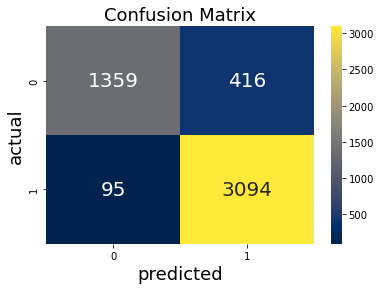


BEST PARAMETERS: {'model__learning_rate': 0.5, 'model__n_estimators': 200, 'vec__ngram_range': (1, 2), 'vec__stop_words': 'english'}

CPU times: user 7min 45s, sys: 525 ms, total: 7min 46s
Wall time: 7min 46s


In [25]:
%%time

params = {
    'vec__stop_words':[None,'english', stops],
    'vec__ngram_range':[(1,1), (1,2)],
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate':[0.001, 0.01, 0.1, 0.5, 1.0]
}

grid(CountVectorizer(), AdaBoostClassifier(random_state=42), params)

In [66]:
# ## EXTRA CODE TO SAVE CONFUSION MATRIX
# cvecc= CountVectorizer(stop_words='english', ngram_range=(1,2))
# adaa = AdaBoostClassifier(learning_rate=0.5, n_estimators=200)

# pipeee = Pipeline([
#     ('cvec', cvecc),
#     ('ada', adaa)
# ])

# pipeee.fit(X_train, y_train)
# predsss = pipeee.predict(X_test)
# cmmm = confusion_matrix(y_test, predsss)


# sns.heatmap(cmmm, cmap= 'cividis', annot=True, fmt='g', annot_kws={'size':20})
# plt.xlabel('predicted', fontsize=18)
# plt.ylabel('actual', fontsize=18)
# plt.title('ADABOOST + CVEC', fontsize=18)
# plt.savefig('../images/ada_cvec_cm.png', dpi=125, facecolor='white')

**TF-IDF Vectorizer + AdaBoost Classifier**

Fitting 3 folds for each of 90 candidates, totalling 270 fits
TRAINING:
Accuracy: 0.9070252034133757

TEST:
Accuracy:  0.8914182111200645

Recall:  0.9642521166509878
Precision:  0.8785714285714286
F1:  0.9194199431903125
ROC_AUC:  0.8624077484663389


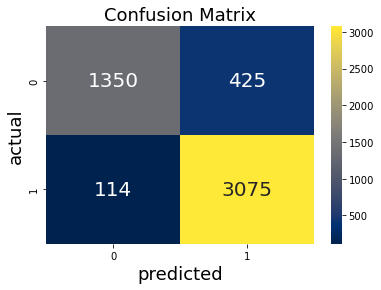


BEST PARAMETERS: {'model__learning_rate': 0.5, 'model__n_estimators': 200, 'vec__ngram_range': (1, 1), 'vec__stop_words': 'english'}

CPU times: user 9min 50s, sys: 1.02 s, total: 9min 51s
Wall time: 9min 51s


In [27]:
%%time

params = {
    'vec__stop_words':[None,'english', stops],
    'vec__ngram_range':[(1,1), (1,2)],
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate':[0.001, 0.01, 0.1, 0.5, 1.0]
}

grid(TfidfVectorizer(), AdaBoostClassifier(random_state=42), params)

## BEST SCORES FROM EACH GRIDSEARCHCV
|  | Count Vectorizer | Parameters | TD-IDF Vectorizer | Parameters |
|---|---:|---:|---:|---:|
| **Logistic Regression** | Training: 0.98154<br>Testing: 0.90713<br>ROC_AUC: 0.88226 | {'model__penalty': 'l2',<br>'vec__max_features': None,<br>'vec__ngram_range': (1, 2),<br>'vec__stop_words': stops} | Training: 0.90812<br>Testing:0.89746<br>ROC_AUC: 0.87036 | {'model__penalty': 'l1',<br>'vec__max_features': 2000,<br>'vec__ngram_range': (1, 2),<br>'vec__stop_words': 'english'} |
| **Random Forest Classifier** | Training: 0.99661<br>Testing: 0.89443<br>ROC_AUC: 0.87812 | {'model__class_weight':<br>'balanced_subsample',<br>'vec__ngram_range': (1, 2),<br>'vec__stop_words': stops} | Training: 0.99633<br>Testing: 0.90169<br>ROC_AUC: 0.88252 | {'model__class_weight': None,<br>'vec__ngram_range': (1, 1),<br>'vec__stop_words': stops} |
| **Support Vector Classifier** | Training: 0.97728<br>Testing: 0.90371<br>ROC_AUC: 0.87972 | {'model__C': 100,<br>'model__gamma': 0.001,<br>'model__kernel': 'rbf',<br>'vec__ngram_range': (1, 2),<br>'vec__stop_words': stops} | Training: 0.98373<br>Testing: 0.91156<br>ROC_AUC: 0.89170 | {'model__C': 10,<br>'model__gamma': 0.1,<br>'model__kernel': 'sigmoid',<br>'vec__ngram_range': (1, 2),<br>'vec__stop_words': stops} |
| **Ada Boost Classifier** | Training: 0.90534<br>Testing: 0.89705<br>ROC_AUC: 0.86792 | {'model__learning_rate': 0.5,<br>'model__n_estimators': 200,<br>'vec__ngram_range': (1, 2),<br>'vec__stop_words': 'english'} | Training: 0.90703<br>Testing: 0.89142<br>ROC_AUC: 0.86241 | {'model__learning_rate': 0.5,<br>'model__n_estimators': 200,<br>'vec__ngram_range': (1, 1),<br>'vec__stop_words': 'english'} |

### SIMPLIFIED TABLE
|  | Count Vectorizer | TD-IDF Vectorizer |
|---|---:|---:|
| **Logistic Regression** | Training: 0.98154<br>Testing: 0.90713<br>ROC_AUC: 0.88226 | Training: 0.90812<br>Testing:0.89746<br>ROC_AUC: 0.87036 |
| **Random Forest Classifier** | Training: 0.99661<br>Testing: 0.89443<br>ROC_AUC: 0.87812 | Training: 0.99633<br>Testing: 0.90169<br>ROC_AUC: 0.88252 |
| **Support Vector Classifier** | Training: 0.97728<br>Testing: 0.90371<br>ROC_AUC: 0.87972 | Training: 0.98373<br>Testing: 0.91156<br>ROC_AUC: 0.89170 |
| **Ada Boost Classifier** | Training: 0.90534<br>Testing: 0.89705<br>ROC_AUC: 0.86792 | Training: 0.90703<br>Testing: 0.89142<br>ROC_AUC: 0.86241 |

### OBSERVATIONS
The model with the lowest variance:
<br>**AdaBoost Classifier with Count Vectorizer**
- Training: 0.90534
- Testing: 0.89705
- ROC_AUC: 0.86792


- Parameters:
    - stop_words = 'english'
    - ngram_range = (1,2)
    - DecisionTreeClassifier(max_depth=1)
    - n_estimators = 200
    - learning_rate = 0.5
    
The model with the highest ROC_AUC:
<br>**Support Vector Classifier with TF-IDF Vectorizer**
- Training: 0.98373
- Testing: 0.91156
- ROC_AUC: 0.89170


- Parameters:
    - stop_words = stops (custom, extending English list)
    - ngram_range = (1,2)
    - kernel = sigmoid
    - gamma = 0.1
    - C = 10

### CONCLUSION 
1. ***The AdaBoost Classifier with Count Vectorization*** would be the safest model for consistent predictions as it can generalize better due to it's low variance and low bias.
2. However, despite having higher variance, ***the Support Vector Classifier with TF-IDF Vectorization*** could also yield good results as it's more capable of distinguishing between each subreddit due to it's higher ROC_AUC value -- also, its testing score is higher afterall and it has a very low bias.


## (BONUS) ADDITIONAL TUNING
As an attempt to attain stronger models, some additional tuning was considered:
1. Random Forest Classifier
    - 'criterion': ["gini", "entropy"]
    - 'n_estimators': [100, 200, 300, 1000]
2. AdaBoost Classifier
    - 'max_depth':[1, 2, 3]

### 1. ADDITIONAL RANDOM FOREST TUNING ON CRITERION & N_ESTIMATORS

**Count Vectorizer + Random Forest Classifier**

Fitting 3 folds for each of 144 candidates, totalling 432 fits
TRAINING:
Accuracy: 0.997717801151022

TEST:
Accuracy:  0.9004834810636584

Recall:  0.9495139542176231
Precision:  0.9009223445403154
F1:  0.9245801526717556
ROC_AUC:  0.8809541602074031


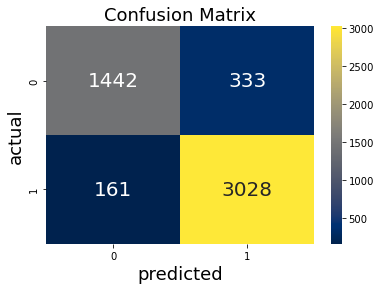


BEST PARAMETERS: {'model__class_weight': None, 'model__criterion': 'entropy', 'model__n_estimators': 300, 'vec__ngram_range': (1, 2), 'vec__stop_words': 'english'}

CPU times: user 25min 18s, sys: 1min 14s, total: 26min 33s
Wall time: 57min 6s


In [39]:
%%time

params = {
    'vec__stop_words':[None, 'english',stops],
    'vec__ngram_range':[(1,1), (1,2)],
#     'model__max_depth': [80, 90, 100, 110],
#     'model__min_samples_leaf': [3, 4, 5],
#     'model__min_samples_split': [8, 10, 12],
    'model__n_estimators': [100, 200, 300, 1000],
    'model__class_weight': [None, 'balanced', 'balanced_subsample'],
    'model__criterion': ["gini", "entropy"]
}

grid(CountVectorizer(), RandomForestClassifier(n_jobs=-1, random_state=42), params)

In [ ]:
# ## SAVED RESULTS DUE TO EXCESSIVE TRAINING TIME (Count Vectorizer + Random Forest Classifier)

    # Fitting 3 folds for each of 144 candidates, totalling 432 fits
    # TRAINING:
    # Accuracy: 0.997717801151022

    # TEST:
    # Accuracy:  0.9004834810636584

    # Recall:  0.9495139542176231
    # Precision:  0.9009223445403154
    # F1:  0.9245801526717556
    # ROC_AUC:  0.8809541602074031


    # BEST PARAMETERS: {'model__class_weight': None, 'model__criterion': 'entropy', 'model__n_estimators': 300, 'vec__ngram_range': (1, 2), 'vec__stop_words': 'english'}

    # CPU times: user 25min 18s, sys: 1min 14s, total: 26min 33s
    # Wall time: 57min 6s

**TF-IDF Vectorizer + Random Forest Classifier**

Fitting 3 folds for each of 144 candidates, totalling 432 fits
TRAINING:
Accuracy: 0.9964278626711649

TEST:
Accuracy:  0.9049153908138597

Recall:  0.9529633113828786
Precision:  0.9041951800059506
F1:  0.9279389312977098
ROC_AUC:  0.8857774303393267


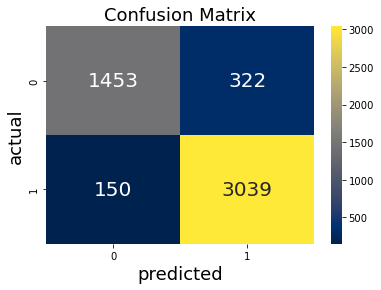


BEST PARAMETERS: {'model__class_weight': None, 'model__criterion': 'entropy', 'model__n_estimators': 1000, 'vec__ngram_range': (1, 1), 'vec__stop_words': {'then', 'nor', 'so', "you'll", 't', "should've", 'she', 'all', 'most', 'own', 's', 'any', 'but', "aren't", 'myself', 'haven', 'be', 'in', 'being', 'is', 'wouldn', 'their', 'when', 'couldn', 'them', 'her', 'an', 'once', 'at', 'mustn', 'on', 'play', 'll', 'out', 'further', "you'd", 'there', 'as', 'time', 'or', 'just', 'should', 'buy', 'want', 'above', 'having', 'are', 'him', 'y', 'hasn', 'yours', 'm', 'now', 'like', 'how', 'yourself', 'wasn', "doesn't", "mustn't", 'yourselves', "it's", "wouldn't", 'best', 'during', 'what', "you're", 'over', 'shan', "couldn't", 'ourselves', 'who', 'theirs', 'was', 'very', 'have', 'for', 'himself', 'after', 'won', 'about', 'by', 'i', 'has', "haven't", 'your', 'herself', 'itself', 'these', 'up', 'know', 'until', 'it', 'did', 'other', 'really', 'does', 'this', 'me', 'mightn', "shouldn't", "you've", 'some'

In [40]:
%%time

params = {
    'vec__stop_words':[None,'english', stops],
    'vec__ngram_range':[(1,1), (1,2)],
#     'model__max_depth': [80, 90, 100, 110],
#     'model__min_samples_leaf': [3, 4, 5],
#     'model__min_samples_split': [8, 10, 12],
    'model__n_estimators': [100, 200, 300, 1000],
    'model__class_weight': [None, 'balanced', 'balanced_subsample'],
    'model__criterion': ["gini", "entropy"]
}

grid(TfidfVectorizer(), RandomForestClassifier(n_jobs=-1, random_state=42), params)

In [ ]:
## OUTPUT SAVED DUE TO EXCESSIVE TRAINING TIME

    # Fitting 3 folds for each of 144 candidates, totalling 432 fits
    # TRAINING:
    # Accuracy: 0.9964278626711649

    # TEST:
    # Accuracy:  0.9049153908138597

    # Recall:  0.9529633113828786
    # Precision:  0.9041951800059506
    # F1:  0.9279389312977098
    # ROC_AUC:  0.8857774303393267


    # BEST PARAMETERS: {'model__class_weight': None, 'model__criterion': 'entropy', 'model__n_estimators': 1000, 'vec__ngram_range': (1, 1), 'vec__stop_words': {'then', 'nor', 'so', "you'll", 't', "should've", 'she', 'all', 'most', 'own', 's', 'any', 'but', "aren't", 'myself', 'haven', 'be', 'in', 'being', 'is', 'wouldn', 'their', 'when', 'couldn', 'them', 'her', 'an', 'once', 'at', 'mustn', 'on', 'play', 'll', 'out', 'further', "you'd", 'there', 'as', 'time', 'or', 'just', 'should', 'buy', 'want', 'above', 'having', 'are', 'him', 'y', 'hasn', 'yours', 'm', 'now', 'like', 'how', 'yourself', 'wasn', "doesn't", "mustn't", 'yourselves', "it's", "wouldn't", 'best', 'during', 'what', "you're", 'over', 'shan', "couldn't", 'ourselves', 'who', 'theirs', 'was', 'very', 'have', 'for', 'himself', 'after', 'won', 'about', 'by', 'i', 'has', "haven't", 'your', 'herself', 'itself', 'these', 'up', 'know', 'until', 'it', 'did', 'other', 'really', 'does', 'this', 'me', 'mightn', "shouldn't", "you've", 'some', "hasn't", 'than', 'had', 'hers', "don't", 'both', "won't", 'aren', 'its', 'before', 'needn', 'few', 'o', 'they', 'd', "hadn't", "wasn't", 'he', 'those', 'why', 'again', 'can', 'more', 'doing', 'down', 'below', 'we', 're', 'were', 'whom', 'against', 'am', 'been', 'each', 'ma', 'looking', "shan't", 'a', 'into', 'didn', 'not', "mightn't", 'ain', 'game', 'same', 'to', 'that', 'here', 'help', 'don', 'and', 'ours', 'hadn', 'shouldn', 'if', "she's", 'between', 'weren', 'because', 'through', 'you', 'will', 'games', 'such', 'which', "didn't", 'from', "isn't", "needn't", 'new', 'his', 'the', 'off', 'no', 'isn', 'of', 'do', 'my', 'under', 'doesn', 'with', 'gaming', "that'll", 'our', 'good', 'too', 'themselves', 'while', "weren't", 'only', 've', 'where'}}

    # CPU times: user 19min 46s, sys: 1min 10s, total: 20min 57s
    # Wall time: 49min 9s

### 2. ADDITIONAL ADABOOST TUNING ON MAX_DEPTH

**Count Vectorizer + AdaBoost Classifier**

Fitting 3 folds for each of 270 candidates, totalling 810 fits
TRAINING:
Accuracy: 0.9300456439769795

TEST:
Accuracy:  0.9002820306204674

Recall:  0.9633113828786454
Precision:  0.8904347826086957
F1:  0.9254405784003614
ROC_AUC:  0.8751768181998861


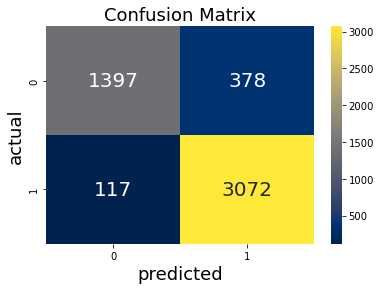


BEST PARAMETERS: {'model__base_estimator': DecisionTreeClassifier(max_depth=3), 'model__base_estimator__max_depth': 3, 'model__learning_rate': 0.1, 'model__n_estimators': 200, 'vec__ngram_range': (1, 2), 'vec__stop_words': None}

CPU times: user 38min 4s, sys: 188 ms, total: 38min 5s
Wall time: 38min 5s


In [32]:
%%time

params = {
    'vec__stop_words':[None,'english', stops],
    'vec__ngram_range':[(1,1), (1,2)],
    'model__base_estimator':[DecisionTreeClassifier()],
    'model__base_estimator__max_depth':[1,2,3],
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate':[0.001, 0.01, 0.1, 0.5, 1.0]
}

grid(CountVectorizer(), AdaBoostClassifier(random_state=42), params)

**TF-IDF Vectorizer + AdaBoost Classifier**

Fitting 3 folds for each of 270 candidates, totalling 810 fits
TRAINING:
Accuracy: 0.9305417741615399

TEST:
Accuracy:  0.8936341659951652

Recall:  0.9601756036375039
Precision:  0.8842044470112619
F1:  0.920625375826819
ROC_AUC:  0.8671300553398787


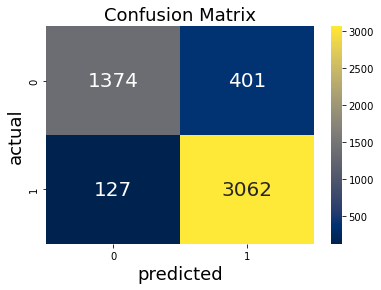


BEST PARAMETERS: {'model__base_estimator': DecisionTreeClassifier(max_depth=3), 'model__base_estimator__max_depth': 3, 'model__learning_rate': 0.1, 'model__n_estimators': 200, 'vec__ngram_range': (1, 1), 'vec__stop_words': {'then', 'nor', 'so', "you'll", 't', "should've", 'she', 'all', 'most', 'own', 's', 'any', 'but', "aren't", 'myself', 'haven', 'be', 'in', 'being', 'is', 'wouldn', 'their', 'when', 'couldn', 'them', 'her', 'an', 'once', 'at', 'mustn', 'on', 'play', 'll', 'out', 'further', "you'd", 'there', 'as', 'time', 'or', 'just', 'should', 'buy', 'want', 'above', 'having', 'are', 'him', 'y', 'hasn', 'yours', 'm', 'now', 'like', 'how', 'yourself', 'wasn', "doesn't", "mustn't", 'yourselves', "it's", "wouldn't", 'best', 'during', 'what', "you're", 'over', 'shan', "couldn't", 'ourselves', 'who', 'theirs', 'was', 'very', 'have', 'for', 'himself', 'after', 'won', 'about', 'by', 'i', 'has', "haven't", 'your', 'herself', 'itself', 'these', 'up', 'know', 'until', 'it', 'did', 'other', 'r

In [33]:
%%time

params = {
    'vec__stop_words':[None,'english', stops],
    'vec__ngram_range':[(1,1), (1,2)],
    'model__base_estimatorAdaBoost Classifier':[DecisionTreeClassifier()],
    'model__base_estimator__max_depth':[1, 2, 3],
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate':[0.001, 0.01, 0.1, 0.5, 1.0]
}

grid(TfidfVectorizer(), AdaBoostClassifier(random_state=42), params)

### ADDITIONAL TUNING RESULTS
|  | Count Vectorizer | Parameters | TD-IDF Vectorizer | Parameters |
|---|---:|---:|---:|---:|
| Random Forest Classifier | Training: 0.99771<br>Testing: 0.90048<br>ROC_AUC: 0.88095 | {'model__class_weight': None,<br>'model__criterion': 'entropy',<br>'model__n_estimators': 300,<br>'vec__ngram_range': (1, 2),<br>'vec__stop_words': 'english'} | Training: 0.99643<br>Testing: 0.90492<br>ROC_AUC: 0.88578 | {'model__class_weight': None,<br>'model__criterion': 'entropy',<br>'model__n_estimators': 1000,<br>'vec__ngram_range': (1, 1),<br>'vec__stop_words': stop} |
| Ada Boost Classifier | Training: 0.93005<br>Testing: 0.90028<br>ROC_AUC: 0.87518 | {'model__base_estimator': DecisionTreeClassifier(max_depth=3),<br>'model__base_estimator__max_depth': 3,<br>'model__learning_rate': 0.1,<br>'model__n_estimators': 200,<br>'vec__ngram_range': (1, 2),<br>'vec__stop_words': None} | Training: 0.93054<br>Testing: 0.89363<br>ROC_AUC: 0.86713 | {'model__base_estimator': DecisionTreeClassifier(max_depth=3),<br>'model__base_estimator__max_depth': 3,<br>'model__learning_rate': 0.1,<br>'model__n_estimators': 200,<br>'vec__ngram_range': (1, 1),<br>'vec__stop_words': stops} |

### SIMPLIFIED TABLE
|  | Count Vectorizer | TD-IDF Vectorizer |
|---|---:|---:|
| Random Forest Classifier | Training: 0.99771<br>Testing: 0.90048<br>ROC_AUC: 0.88095 | Training: 0.99643<br>Testing: 0.90492<br>ROC_AUC: 0.88578 |
| Ada Boost Classifier | Training: 0.93005<br>Testing: 0.90028<br>ROC_AUC: 0.87518 | Training: 0.93054<br>Testing: 0.89363<br>ROC_AUC: 0.86713 |

### PREVIOUS SCORES
|  | Count Vectorizer | TD-IDF Vectorizer |
|---|---:|---:|
| **Random Forest Classifier** | Training: 0.99661<br>Testing: 0.89443<br>ROC_AUC: 0.87812 | Training: 0.99633<br>Testing: 0.90169<br>ROC_AUC: 0.88252 |
| **Ada Boost Classifier** | Training: 0.90534<br>Testing: 0.89705<br>ROC_AUC: 0.86792 | Training: 0.90703<br>Testing: 0.89142<br>ROC_AUC: 0.86241 |

### ADDITIONAL TUNING OBSERVATION & CONCLUSION
The additional tuning yielded **slightly higher training & test scores as well as ROC_AUC,** but the ***previous observation & conclusion*** of the lowest variance model and the highest ROC_AUC model still holds true:

The model with the lowest variance:
<br>**AdaBoost Classifier with Count Vectorizer (before additional tuning)**
- Training: 0.90534
- Testing: 0.89705
- ROC_AUC: 0.86792

The model with the highest ROC_AUC:
<br>**Support Vector Classifier with TF-IDF Vectorizer**
- Training: 0.98373
- Testing: 0.91156
- ROC_AUC: 0.89170

Therefore, the additional tuning was not necessary.

## FEATURE IMPORTANCE
Let's observe the feature importances from the 1 of top 2 models selected:
- **AdaBoost Classifer + Count Vectorizer**
    - SVC + TF-IDF Vectorizer is not linear (kernel='sigmoid')
        - cannot extract coefficients to determine feature importance

### 1. ADABOOST + COUNT

In [23]:
# Refit based on best estimators

# AdaBoost + Count 
cvec = CountVectorizer(ngram_range=(1,2), stop_words='english')
abc = AdaBoostClassifier(random_state=42, learning_rate=0.5, n_estimators=200)

pipe1 = Pipeline([('cvec', cvec),
                  ('abc', abc)])

pipe1.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(ngram_range=(1, 2), stop_words='english')),
                ('abc',
                 AdaBoostClassifier(learning_rate=0.5, n_estimators=200,
                                    random_state=42))])

In [24]:
# Scores confirmed
print(pipe1.score(X_train, y_train))
print(pipe1.score(X_test, y_test))

0.9053383607858703
0.8970588235294118


In [35]:
# Feature names 
features1 = cvec.get_feature_names()
importance1 = abc.feature_importances_.argsort()

# To dataframe for visual presentation
abc_df = pd.DataFrame(data=importance1, columns=['feature_importance'], index=features1)

# Top 5 & bottom 5 feature importances
abc_df = abc_df.sort_values('feature_importance', ascending=False)
abc_df

,feature_importance
youtube damn,127844
cores radeon,127843
games gotten,127842
games grand,127841
games granted,127840
...,...
prevalent snes,4
prevent,3
prevent damage,2
prevent dust,1


In [72]:
# About the top 4000 features consisted of combinations of
# game/games/gaming
abc_df[3995:4010]

,feature_importance
game original,123849
game originally,123848
game ostensibly,123847
game outdated,123846
game overall,123845
gaming rise,123844
gauntlet formula,123843
grrms qr,123842
gauntlets,123841
got million,123840


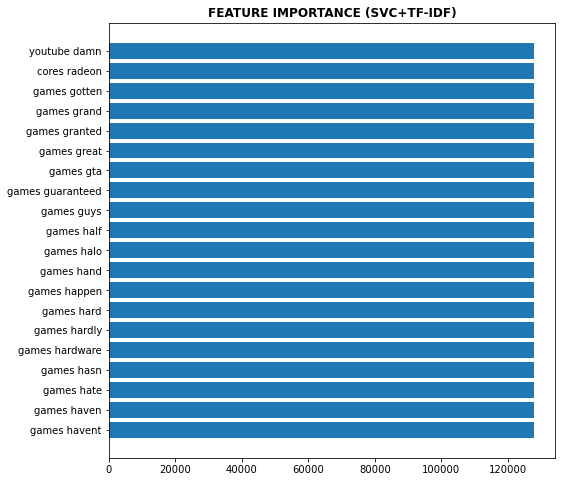

In [41]:
# Horizontal bar chart for visual
top_abc = abc_df.head(20)

plt.figure(figsize=(8,8))
plt.title('FEATURE IMPORTANCE (SVC+TF-IDF)', weight='bold')
plt.barh(top_abc.index, top_abc['feature_importance'][:20])
plt.gca().invert_yaxis()

## Plotting doesn't really make sense since the top features
## have a differnce of 1 between each other
## starting from the highest value of 127844

### (ADABOOST+COUNT) FEATURE IMPORTANCE OBSERVATION
It seems that many combinations of games + "word" had an impact on the models performance in predicting the PC Gaming subreddit.

As the model was tuned to only remove the original 'English' stop words instead of the custom one, this was to be expected. 

### 2. SVC + TF-IDF
Since the best SVC model is non-linear, we'll tune for a linear SVC model and take a look at the coefficients.

In [100]:
# Utilizing the same vectorizer parameters
# Only tuning gamma and C
tfid = TfidfVectorizer(ngram_range=(1,2), stop_words=stops)
svc = SVC(random_state=42, kernel='linear')

params_svc = {'svc__C':[0.1, 1, 10, 100],
          'svc__gamma': [1, 0.1, 0.01, 0.001]}

pipe2 = Pipeline([('tfid', tfid),
                  ('svc', svc)])

gs = GridSearchCV(pipe2,
                 params_svc,
                 cv=3,
                 verbose=1)

gs.fit(X_train, y_train)
best_gs = gs.best_estimator_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [102]:
# Scores
best_gs.fit(X_train, y_train)
print(best_gs.score(X_train, y_train))
print(best_gs.score(X_test, y_test))
print(roc_auc_score(y_test, best_gs.predict(X_test)))
print()
print(gs.best_params_)

    ## Suprisingly comparable to the best SVC model

0.9840246080571542
0.911563255439162
0.8917008731599381

{'svc__C': 1, 'svc__gamma': 1}


### Surpisingly identical (slightly better) than the best SVC model (kernel='sigmoid')
Support Vector Classifier with TF-IDF Vectorizer 
- Training: 0.98373
- Testing: 0.91156
- ROC_AUC: 0.89170


- Parameters:
    - kernal='linear'
    - C=1
    - gamma=1

**I should've included 'linear' in the list of kernals during the SVC hypertuning.**

In [26]:
# Refit based on best estimators

# SCV + TF_IDF 
tfid = TfidfVectorizer(ngram_range=(1,2), stop_words=stops)
svc = SVC(random_state=42, kernel='linear', gamma=1, C=1)

pipe2 = Pipeline([('tfid', tfid),
                  ('svc', svc)])

pipe2.fit(X_train, y_train)

Pipeline(steps=[('tfid',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'best',
                                             'between', 'both', 'but', 'buy',
                                             'by', 'can', ...})),
                ('svc', SVC(C=1, gamma=1, kernel='linear', random_state=42))])

In [27]:
# Scores confirmed
print(pipe2.score(X_train, y_train))
print(pipe2.score(X_test, y_test))

0.9840246080571542
0.911563255439162


In [33]:
# Feature names 
features2 = tfid.get_feature_names()
importance2 = svc.coef_.toarray().T

# Dataframe
svc_df = pd.DataFrame(data=importance2, columns=['feature_importance'], index=features2)

# Top 5 & bottom 5 feature importances
svc_df = svc_df.sort_values('feature_importance', ascending=False)
svc_df

## Top 5 = best 5 for predicting PC Gaming subreddit
## Bottom 5 = best 5 for predicting Console Gaming subreddit 

,feature_importance
pc,4.434032
steam,2.812331
pc ps,1.720665
windows,1.527576
one controller,1.494258
...,...
nintendo,-5.000389
xbox,-5.502925
consoles,-6.815943
ps,-7.800251


In [59]:
svc_df.head(10)

,feature_importance
pc,4.434032
steam,2.812331
pc ps,1.720665
windows,1.527576
one controller,1.494258
xbox app,1.477866
console player,1.445478
player,1.417145
controller pc,1.384644
laptop,1.377184


In [60]:
svc_df.tail(10)

,feature_importance
xbox one,-2.948043
ds,-3.134904
switch,-3.231107
wii,-3.640312
playstation,-4.484609
nintendo,-5.000389
xbox,-5.502925
consoles,-6.815943
ps,-7.800251
console,-8.729208


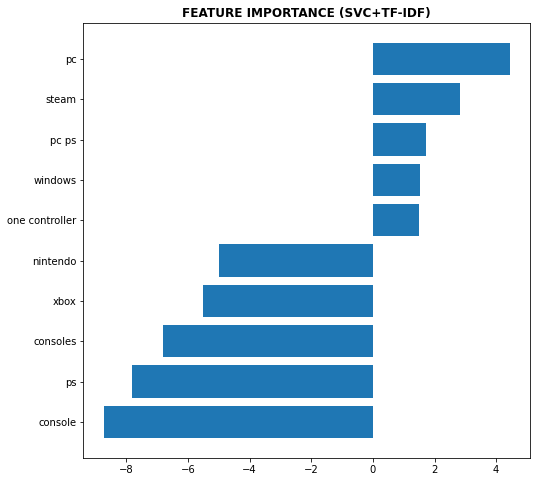

In [55]:
# Horizontal bar chart for visual
top_svc = pd.concat([svc_df.head(),svc_df.tail()])

plt.figure(figsize=(8,8))
plt.title('FEATURE IMPORTANCE (SVC+TF-IDF)', weight='bold')
plt.barh(top_svc.index, top_svc['feature_importance'][:20])
plt.gca().invert_yaxis()
plt.savefig(fname='../images/svc_importance.png', dpi=75)

### (SVC+TF-IDF) FEATURE IMPORTANCE OBSERVATION
Since the custom stop words list was used for removal, we no longer see combinations of "games" + "words" compared to the previous list.
<br>Instead more distinctive single words have a heavier level of importance (along with some two word combinations that consist of the listed single words).

Examples:
- pc
- steam
- windows
- laptop
- player
- controller
- console/consoles
- ps/playstation
- xbox

**This further supports that fact that this model has a strong performance with separability (higher ROC_AUC).**

# FINAL CONCLUSION
To achieve the goal of correctly predicting whether a post belongs to subreddit r/pcgaming or r/consoles, one of the two models can be utilized:
1. **ADABOOST CLASSIFIER with COUNT VECTORIZATION**
    - lowest variance for consistent predictions and best generalization
    
    
2. **SUPPORT VECTOR CLASSIFER with TF-IDF VECTORIZATION**
    - highest roc_auc for strong separability performance (and lowest bias)
    
### RECOMENDATIONS
1. Implement lemmatization or stemming. Looking in retrospect, tuning between lemmatizing, stemming, or neither may potentially yield better results.
2. Repeat the analysis once the console gaming community has expanded by a lot and has at least 10000 posts.
3. As a large portion of posts were image-only posts, incorporating an image processing method could provide more information and potentially useful features.